# fMRI Data Loading and Normalization in Python 
**V.0.2 - Beta, [Contributions](#contributions)** 

In cognitive neuroscience, what was considered impossible a few decades ago, is now doable. Today, we can infer certain aspects of a persons cognitive processes from measurements of brain activity. This progress has come about due to a confluence of improvements in three different areas: computing speeds, brain imaging methods, and efficient machine learning algorithms. To use all these three aspects for our data analysis, in an optimum manner, involves learning a complex sequence of steps. Our overarching goal for these tutorials, is to provide a step-by-step walk-through on how to execute this complex sequence of analysis and infer cognitive states from brain activity.

The first steps in this process begin with running experiments and collecting fMRI data. Then, this collected data then undergoes a sequence of steps, called preprocessing, involving corrections, transformations, and alignments before we can extract relevant signal. Only after these steps have been completed is the data ready for analysis by machine learning algorithms. This preprocessed fMRI data is commonly stored in the NIfTI format, and we will use this preprocessed data as the starting point for our analysis.

In this tutorial, our aim is to cover the very first step in the analysis: pre-processed fMRI data extraction and normalization. For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017). This dataset will heretofore be referred to as the "VDC" dataset. For the localizer, subjects were shown blocks of faces, scenes and objects in 3 separate runs.

**Note:** If you need help understanding terms such as "localizer", "blocks", "runs", please refer to the fMRI information on the NEU480 "Resources" page.  

### Goal of this script
Using this script you will learn to visualize and normalize your data. Specifically, you will learn the following:
 1. load the fMRI data into python
 2. plot a timeseries for a voxel
 3. Z-score the data -- an important normalization step for machine learning 

If you would like to learn more about fMRI preprocessing, you can find some useful lecture material here: https://fsl.fmrib.ox.ac.uk/fslcourse/ (scroll down to 'Lecture slides & Practical Data').

## Table of Contents
[1. Import necessary packages](#import)  

[2. Load in timing files](#load_timing)  
>[2.1 Timing file description](#load_timing_describe)  
>[2.2 Plot stimulus presentation](#plot)  

[3. Load fMRI](#load_fmri)  
>[3.1 Plot voxel time series](#plot_voxel)  

[4. Normalization](#zscore)  
>[4.1 Check the z scoring](#zscore_check)  

Exercises
>[Exercise 1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) 

>[Novel contribution](#novel)  

## 1. Import necessary packages <a id="import"></a> 
The following packages will be used:  
>nibabel: Read  fMRI data into python arrays.  
>numpy: Perform numerical operations in python.   
>scipy: Scientific computing methods.  
>nilearn: Used to extract masked fMRI data from a NIfTI file.  
>sklearn: Machine Learning methods.  
>matplotlib, sns: Plotting libraries.  

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


### 1.1 Helper Functions

To make it easy for you to achieve the main goals of this notebook, we have created helper functions that do the heavy lifting in terms of data extraction. Thus a complex set of steps to load data, across NIfTI and matlab file formats, from multiple runs, is executed in few lines of code in this notebook. In future notebooks, you will be exposed to more details of data extraction. The helper functions are all in the `utils.py` program. This program may be found in the same folder as the notebooks.

In [3]:
# load some helper functions
from utils import load_vdc_stim_labels, load_vdc_mask, load_vdc_epi_data
# load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs

print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %d' % (vdc_n_runs))

data dir = /home/NEU480/datasets/vdc/
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3


<div class="alert alert-block alert-warning">
<strong> Note on data file paths:</strong> The data directory points to a specific location on the Adroit cluster, for the NEU480 class, at Princeton University, <strong> and no change to the path is required </strong>. If you are not in the NEU480 class or running on another cluster (e.g., scotty or spock) you will need to make a change to the data file path variable `vdc_data_dir` in `utils.py`.  
<br>

<strong>If you are not in the Princeton or Yale class</strong>, that uses this dataset, check the brainiak tutorial repository for information on where to download this dataset.
</div>

**Exercise 1:**<a id="ex1"></a> Describe the difference in functionality between 'import numpy' and 'from numpy import zeros':



## 2. Load in timing files<a id="load_timing"></a>

The first way we are going to examine this dataset, heretofore referred to as the "vdc" dataset, is by looking at the timing of events in the experiment. The labels for each run of the experiment are stored in the localizer matlab file (e.g., `sub-01_localizer_01.mat`). We will read and plot the data that show which stimulus was presented at what time during the experiment. The columns in the localizer matlab file represent time in the experiment.

**Self-study:** Navigate through the folder that contains these data (defined in `vdc_data_dir`) to get an understanding of the file structure. Open up the files and look at their contents. Be an explorer!

### 2.1 Timing file description <a id="load_timing_describe"></a>
The localizer consists of 3 runs. Each run contained 15 blocks, with 5 blocks from each of 3 stimulus categories: faces, scenes and objects. There were 10 trials per block. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there were 15s (10 TRs) of fixation. Each run was approximately 310 TRs. 

There is a bunch of information about each run in the matlab stimulus file that we are about to load. Each row contains a different type of information (e.g., stimulus type, reaction time, etc.) and each column represents a different trial. 

Of most importance to us, the first row has the stimulus labels for the localizer runs; whereas the third row contains the time in seconds when the stimulus was presented (relative to the start of each run). The data were loaded in such that the three runs were concatenated in time i.e. columns were added for each run.

The stimulus labels used in row 1 and their corresponding categories are as follows:  
1= Faces  
2= Scenes  
3= Objects 

<div class="alert alert-block alert-info">
<strong> Reminder: Python row and column indexing-- everything begins at [0], not [1].</strong>
<br>
When we refer to the first line of a file, and we call it row 1, it is indexed as row [0] in Python. Subsequently, each line number in a file (e.g. row n)  will be indexed in Python as [n-1].
</div>

In [4]:
sub = 'sub-01'

stim_label_allruns = load_vdc_stim_labels(sub)
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))

# Because Python suppresses output (when there is no error), you may want to include print statements at the end of 
# cells to indicate to you when a cell has executed all lines of code

stim_label_allruns has shape:  (10, 450)


When analyzing data it is important to keep checking whether the code you wrote actually does what you intend it to do. For example, one possible thing to check is whether the created output variable stim_label_allruns indeed contains the expected number of rows and columns. We use a function from the imported numpy package for this purpose: np.shape(stim_label_allruns). Of course, there are plenty of other ways to check whether your code works the way you want it to work.

**Exercise 2:**<a id="ex2"></a> How big is the dataset in terms of number of subjects?



### 2.2 Plot stimulus presentation <a id="plot_timing"></a>

Of course, you can look at the timeline of the stimulus presentation by selecting these rows and output them as an array of values (stim_label_allruns[0,:] and stim_label_allruns[2,:]). However, a better way of visualizing the timeline of the stimulus presentation is by creating a plot, which we will now teach you by using the plotting package matplotlib (that you have imported earlier in this script).

**Self-study:** Don't know what a python dictionary is? Look it up!


In [5]:
# choose a run 
run_id = 2

# select the corresponding time points for a given run
# The 6th row is the run identifier for a particular run.
time_points_mask = stim_label_allruns[5,:] == run_id

# the 1st row (index =0) is the labels of the stimuli 
labels = stim_label_allruns[0, time_points_mask]

# the 3rd row (index =2) is time in secs 
time_secs = stim_label_allruns[2, time_points_mask]

print('labels:\n\n %s \n\n' % labels)
print('time_secs:\n\n%s' % time_secs)

labels:

 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.] 


time_secs:

[ 12.   13.5  15.   16.5  18.   19.5  21.   22.5  24.   25.5  42.   43.5
  45.   46.5  48.   49.5  51.   52.5  54.   55.5  72.   73.5  75.   76.5
  78.   79.5  81.   82.5  84.   85.5 102.  103.5 105.  106.5 108.  109.5
 111.  112.5 114.  115.5 132.  133.5 135.  136.5 138.  139.5 141.  142.5
 144.  145.5 162.  163.5 165.  166.5 168.  169.5 171.  172.5 174.  175.5
 192.  193.5 195.  196.5 198.  199.5 201.  202.5 204.  205.5 222.  223.5
 225.  226.5 228.  229.5 231.  232.5 234.  235.5 252.  253.5 255.  256.5
 258. 

#### Here's the minimal structure of a matplotlib plot

Text(0.5,0,'time in secs')

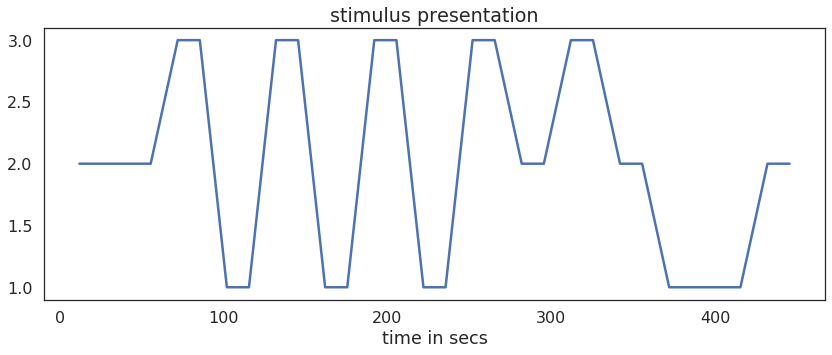

In [6]:
# create a 1 x 1 figure panel 
f, ax = plt.subplots(1, 1, figsize = (14, 5))

# then ax.plot(x, y) will create a line plot 
ax.plot(time_secs, labels)

# you can add plot title like this
ax.set_title('stimulus presentation')

# you can set xlabel like this
ax.set_xlabel('time in secs')

#### Can you explain what the plot is visualizing? 
#### The plot above is not very informative. Below, we add more identifiers to the plot to make it more meaningful. 

Text(0.5,0,'Time (seconds)')

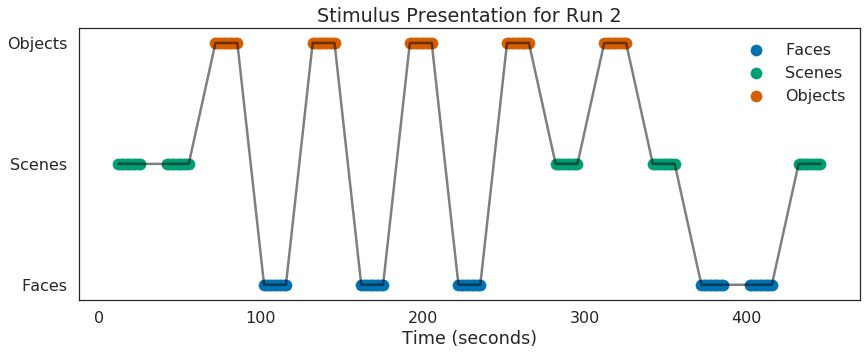

In [7]:
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# create a plotting panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_secs[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())

# connect the dots 
ax.plot(time_secs, labels, color = 'black', alpha = .5)

# mark the plot
ax.set_title('Stimulus Presentation for Run %d' % (run_id))
ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())
ax.set_xlabel('Time (seconds)')

**Exercise 3:**<a id="ex3"></a> Plot the stimulus presentation for runs 2 and 3 for this subject.

**Exercise 4:**<a id="ex4"></a> How many stimuli were presented in each block?

**Exercise 5:**<a id="ex5"></a> Is the stimulus presented in the same order for all the three runs?

## 3. Load fMRI data <a id="load_fmri"></a>

We'll load the data for one run. We will also extract a subset of the signal from the whole-brain data by using a mask for the "fusiform face area" ('FFA').

In [8]:
print('Here\'re the available ROIs: ', vdc_all_ROIs)

Here're the available ROIs:  ['FFA', 'PPA']


#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the mask of FFA 
3. use `NiftiMasker` to sub-select FFA voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

In [9]:
# choose FFA
ROI_name = 'FFA'

# 1. Load the fMRI data 
epi_data = load_vdc_epi_data(sub, run_id)
# 2. Load the mask file 
mask = load_vdc_mask(ROI_name, sub)
# 3. Apply ROI mask
nifti_masker = NiftiMasker(mask_img=mask)
maskedData = nifti_masker.fit_transform(epi_data)

print('data shape - before masking: ', epi_data.shape)
print('data shape - after masking: ', maskedData.shape)
print('mask name: ', ROI_name)

Loading data from /home/NEU480/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loaded FFA mask
data shape - before masking:  (128, 128, 52, 310)
data shape - after masking:  (310, 5519)
mask name:  FFA


**Self-study:** Not quite sure how the process of applying the mask worked in detail? Check out the documentation of the function we used (nilearn.input_data.NiftiMasker).

**Self-study:** The PPA is listed as an ROI in vdc_all_ROIs. What is the parahippocampal place area (PPA)?

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in your mask, FFA in this example).

Text(0,0.5,'Voxel Intensity')

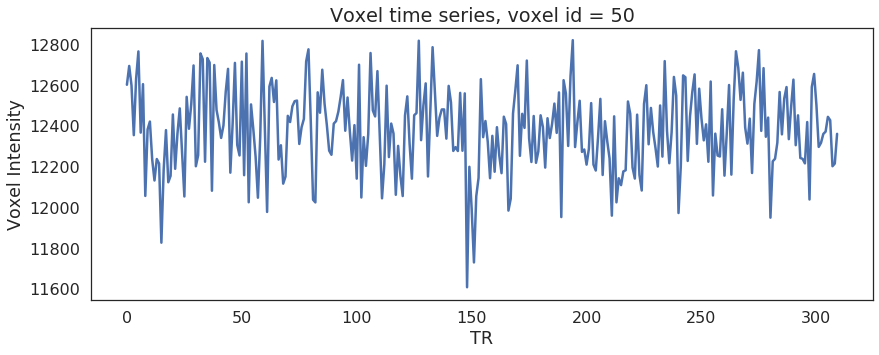

In [10]:
# Plot a voxel value (in this example of voxel 100) through time
time_id = 100
voxel_id = 50

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(maskedData[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

## 4. Normalization <a id="zscore"></a>

There are many ways to normalize the data. Z-scoring is one of the most common approaches: we center the data to mean zero and a standard deviation of one ($\mu=0, \sigma = 1$). Why do we scale the data? See here: http://scikit-learn.org/stable/modules/preprocessing.html

 We will use the StandardScaler method to accomplish this. 

**Self-study:** Explore other normalization techniques in the link above.

`StandardScaler` is a function from `sklearn.preprocessing`. `sklearn` functions tend to have the following generate usage: 

- step 1: `sklearn_function.fit(some_data)`, which returns as fitted model
- step 2: `sklearn_function.transform(some_data)`, which returns the transformed data 

The following example should make this clear... 

In [11]:
# z score the data 
# the following procedure normalize the response within voxels over time
scaler = preprocessing.StandardScaler().fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)

### 4.1 Check the z scoring <a id="zscore_check"></a>

The mean values never equal exactly zero. This happens because of rounding and precision limitations. These small values are considered zero for most practical purposes. We can print out the values. Also check that the standard deviation is now correct.

In [12]:
x_mean = np.mean(maskedData_zscore, axis=0)
x_std = np.std(maskedData_zscore, axis=0)
print('the mean of 1st few time points:\n', x_mean[0:10])
print('the std of 1st few time points:\n', x_std[0:10])
print(np.shape(x_mean))

the mean of 1st few time points:
 [-1.4776569e-05 -4.7838016e-06  9.3490844e-06  1.0291223e-05
 -9.6640279e-06  2.3351562e-05 -2.3142080e-05  1.8464365e-05
  1.5677945e-06 -9.5986552e-06]
the std of 1st few time points:
 [1.        0.9999998 0.9999998 0.9999998 1.        0.9999999 1.0000001
 0.9999998 1.        1.0000002]
(5519,)


**Exercise 6:**<a id="ex6"></a> compared the raw data vs. the z-scored data

**Exercise 7:**<a id="ex7"></a> Plot the distribution of values as a histogram. Sample histogram code can be found [here.](https://matplotlib.org/examples/statistics/histogram_demo_histtypes.html)


**Exercise 8:**<a id="ex8"></a> Z-score the data by writing your own code instead of using the StandardScaler() method.


**Exercise 9:** <a id="ex9"></a>We have a new dataset that needs some investigating. In this dataset, called **'lab1'**, we have three conditions A, B, and C. We extracted data for these three conditions from a brain region called **ROI_Cool**. If we examine the signal mean values for these three conditions, we see that the mean values differ, but there is a large variability (evidenced by large confidence intervals). In fact, the confidence intervals for conditions A and B slightly overlap. Using the techniques you have learnt in this lab, investigate this dataset and determine if the brain response differs for these three conditions in the brain region defined by ROI_Cool.

**Note1:** We have provided all the code needed to extract the signal from ROI_Cool. We have data for 9 runs. You should use the functions provided below to complete your analysis.

**Note2:** The output from a MRI machine is a series of numbers on an arbitrary scale. We often measure the difference of mean values between two conditions (often referred to as univariate analysis). Hence, in this exercise, to determine how large the signal for condition A is, the difference between the signal (e.g. condition A: `bold_A`) and the baseline, `bold_fix`, is the critical measure.

**Baseline:** In block design experiments, the intervening time period between blocks of interest is called baseline. Typically, subjects are shown a blank screen with a fixation cross at the center. 

**Functions:** The program `lab1.py` contains functions that load and extract the data for the different condition for each timepoint. You do not need to modify any of these functions for this exercise. These functions will be imported from `lab1.py` and used for this exercise.

> `get_bold_for_condition()`: Extracts bold data for the different conditions for all runs.  
> `compute_mean_diff()`: Returns the difference between the signal mean and the baseline mean for each run, for each array.  
> `compute_stats`: Computes, means, standard errors and confidence intervals.

**9.1. Signal extraction**  
We first extract the data, for the `ROI_Cool` mask, for the different conditions. The variables are defined as follows:  
>`bold_data_all`: The concatenated BOLD data for all the runs, for all the conditions.   
>`bold_mean_all`: The mean of the BOLD data for each run, for all the conditions.  
>`bold_A`, `bold_B`, `bold_C`: The concatenated BOLD data for conditions A, B, and C respectively.  
>`labels`: The labels for each timepoint.

In [13]:
dir_input = '/home/NEU480/datasets/lab1/' # data folder containing the data for 9 runs, the label files and the mask.
num_runs =9
# Extract the BOLD Signal for the conditions A, B, C.
# This data is not normalized.

from lab1 import get_bold_for_condition, compute_mean_diff, compute_stats

bold_data_all, bold_mean_all,bold_A, bold_B, bold_C, bold_fix, labels =  get_bold_for_condition(dir_input,
                                                                                                num_runs,
                                                                                                option_zscore=0)

Processing Start ...
Loaded Mask
(53, 63, 46)
Processing Completed


**9.2. Compute signal mean and statistics**  
We compute the mean effect for conditions A, B, and C. We also compute statistics for each of the three conditions. This will allow us to infer differences between the three conditions.

`m`: mean  
`std_err`: standard error  
`h`: Width of confidence interval  
`interval`: confidence interval  

In [14]:
diff_raw = compute_mean_diff(num_runs,bold_A, bold_B, bold_C, bold_fix)
[m, std_err, h, interval] = compute_stats(diff_raw, 0.95)

**9.3: The problem: Conditions A and B do not differ in the mean response evoked.** 

We plot the means and confidence interval below (Figure 9.1). From this figure you may observe the large confidence intervals around the mean values in the bar plot. Moreover, conditions A, B have overlapping confidence intervals. This implies that there is no difference between these two conditions. Is there no difference between conditions A and B in this dataset?

We also cannot be quite sure of the actual effect size of Condition C. From the large confidence interval for condition C, the mean value cannot be precisely pin pointed.

([<matplotlib.axis.XTick at 0x2af6adb454e0>,
 <a list of 3 Text xticklabel objects>)

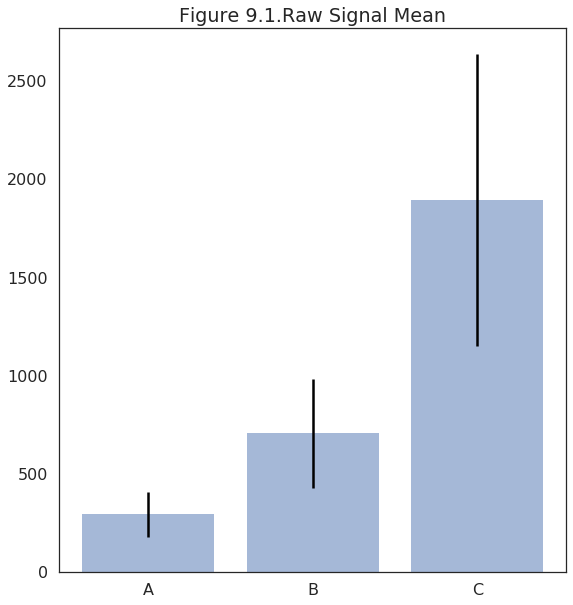

In [15]:
plt.figure(figsize=(20,10))
cond = ('A','B','C')
plt.subplot(121)
plt.title('Figure 9.1.Raw Signal Mean')
y_pos = [1,2,3]
plt.bar(y_pos, np.mean(diff_raw, axis=1), align='center', yerr=h/2,alpha=0.5)
plt.xticks([1, 2, 3], ['A', 'B', 'C'])

**9.4: Take a closer look at the data.** 

When we encounter problems like this, it is best to start by looking at the individual data points that make up the mean. Are there one or more data points, that are outliers, that could cause such effects? To investigate this, we plot the mean effect (`diff_raw`), for each condition, for each run.

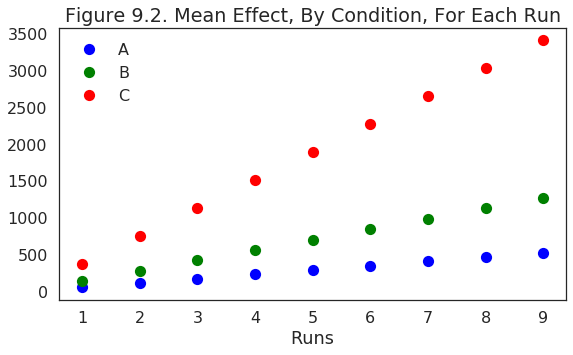

In [16]:
plt.figure(figsize=(20,5))
ax=plt.subplot(121)
plt.title("Figure 9.2. Mean Effect, By Condition, For Each Run")
ax.plot((diff_raw[0]),'o',color="b", label='A')
ax.plot(diff_raw[1],'o',color="g", label='B')
ax.plot(diff_raw[2],'o',color="r", label='C')
plt.xticks(range(0,9),range(1,10))
plt.xlabel('Runs')
leg=ax.legend()

**Observation:** In the figure above (Figure 9.2), we see that there is a difference in the mean effect for each condition, for each run. If we are to look across runs we also see a striking increase in the effect across runs. In addition to a within run effect, there seems to be an across run effect. This could lead to an increased variance in our measurements.

We can make one final check to see if there is a gradual increase to each run. We plot the mean of the overall BOLD signal for each run below.

Text(0.5,0,'Runs')

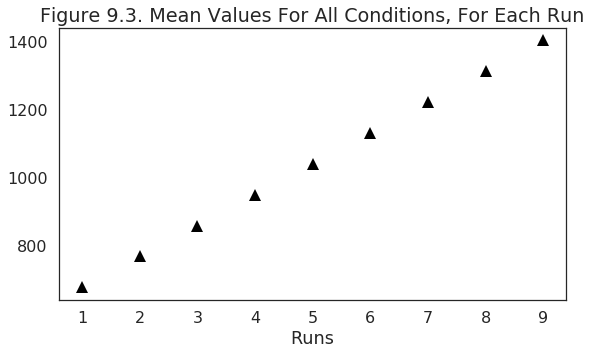

In [17]:
plt.figure(figsize=(20,5))

# Plot the mean value of the entire signal for each run.
plt.subplot(122)
plt.title("Figure 9.3. Mean Values For All Conditions, For Each Run")
plt.plot(bold_mean_all,'^',c='k')
plt.xticks(range(0,9),range(1,10))
plt.xlabel('Runs')

**Observation:** Indeed, there is an increase in the overall mean of the signal across runs (Figure 9.3)! The runs seem to be starting at different levels. This leads to increased variability in the measurements.  

**Exercise 9:** Put these runs on an equal footing (z-score) and reanalyze this dataset by repeating the analyses and plots above on the z-scored data. In doing so address the following questions; 
i) Do conditions A and B differ in this dataset? 
ii) For condition C, given the large variation shown above, is it correct to assume that condition C varies a lot? 
Justify your answers, with your analysis steps and figures. 


## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  
T. Meissner minor edits  
Q. Lu switch to matplotlib, color blind friendly colors, encapsulate helper functions, del ex.3 (loop)  
Manoj: Added Exercise 10, deleted masking exercise.